<a href="https://colab.research.google.com/github/itsamekadio/Numerical_Methods_Course/blob/main/week_7_(spline_interpolation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Higher-order polynomials may tend to swing through wild
oscillations in the vicinity of an abrupt change.

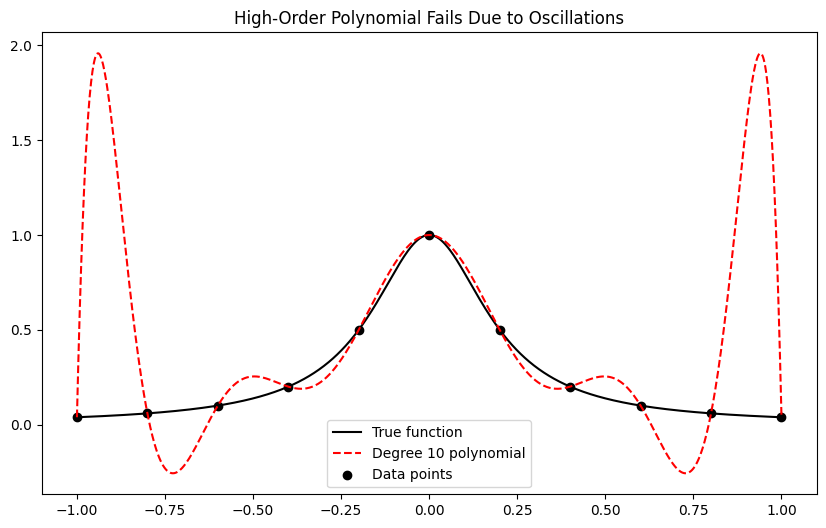

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Example: Runge's function
def runge(x):
    return 1 / (1 + 25 * x**2)

# Generate data
x = np.linspace(-1, 1, 11)
y = runge(x)

# High-order polynomial fit
poly_coeffs = np.polyfit(x, y, deg=len(x)-1)
poly = np.poly1d(poly_coeffs)
x_fine = np.linspace(-1, 1, 1000)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_fine, runge(x_fine), 'k-', label="True function")
plt.plot(x_fine, poly(x_fine), 'r--', label=f"Degree {len(x)-1} polynomial")
plt.scatter(x, y, color='black', label="Data points")
plt.legend()
plt.title("High-Order Polynomial Fails Due to Oscillations")
plt.show()

 Linear Splines: Simple but Limited
Linear splines are just piecewise linear interpolation (1st-order polynomials).

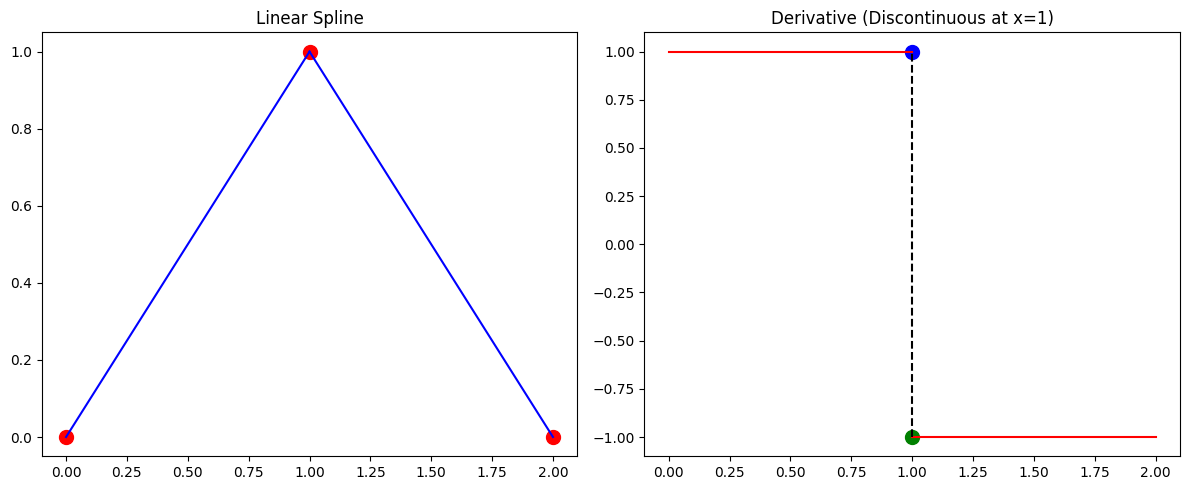

In [12]:
def make_linear_spline(x_points, y_points):
    """Creates a linear spline function from given points"""
    segments = []

    # Create linear functions for each segment
    for i in range(len(x_points)-1):
        x1, x2 = x_points[i], x_points[i+1]
        y1, y2 = y_points[i], y_points[i+1]
        slope = (y2 - y1)/(x2 - x1)

        def segment_func(x, x1=x1, y1=y1, slope=slope):
            return y1 + slope*(x - x1)

        segments.append((x1, x2, segment_func))

    # Main spline function
    def spline(x):
        for x1, x2, func in segments:
            if x1 <= x <= x2:
                return func(x)
        return None  # outside range

    return spline
def make_spline_derivative(x_points, y_points):
    """Creates the derivative function of the spline"""
    derivatives = []

    for i in range(len(x_points)-1):
        slope = (y_points[i+1] - y_points[i])/(x_points[i+1] - x_points[i])
        derivatives.append((x_points[i], x_points[i+1], slope))

    def derivative(x):
        for x1, x2, slope in derivatives:
            if x1 <= x <= x2:
                return slope
        return None

    return derivative
# Our data points (3 points = 2 segments)
x_data = [0, 1, 2]
y_data = [0, 1, 0]

# Create the functions
spline = make_linear_spline(x_data, y_data)
derivative = make_spline_derivative(x_data, y_data)

# Test points (avoid exact knots for clear plotting)
test_points = [0.1, 0.5, 0.9, 1.1, 1.5, 1.9]
import matplotlib.pyplot as plt

# Plot the spline
plt.figure(figsize=(12,5))

# Spline plot
plt.subplot(1,2,1)
for i in range(len(x_data)-1):
    seg_x = [x_data[i], x_data[i+1]]
    seg_y = [y_data[i], y_data[i+1]]
    plt.plot(seg_x, seg_y, 'b-')
plt.scatter(x_data, y_data, color='red', s=100)
plt.title("Linear Spline")

# Derivative plot
plt.subplot(1,2,2)
for i in range(len(x_data)-1):
    seg_x = [x_data[i], x_data[i+1]]
    slope = (y_data[i+1]-y_data[i])/(x_data[i+1]-x_data[i])
    plt.plot(seg_x, [slope, slope], 'r-')

# Mark the discontinuity
plt.plot([1,1], [-1, 1], 'k--')  # Vertical line at x=1
plt.scatter([1], [1], color='blue', s=100)   # Left derivative
plt.scatter([1], [-1], color='green', s=100)  # Right derivative
plt.title("Derivative (Discontinuous at x=1)")

plt.tight_layout()
plt.show()

As we can see not diffrentiable as we have sharp points and the kind of discontiniuty is not that of a vertical tangent rather one of 2 tangents
**So now we use what solves this problem aka QUADRATIC SPLINES**

Spline coefficients:
Segment 1 (3.0 ≤ x ≤ 4.5):
  f(x) = 0.000000x² + -1.000000x + 5.500000
Segment 2 (4.5 ≤ x ≤ 7.0):
  f(x) = 0.640000x² + -6.760000x + 18.460000
Segment 3 (7.0 ≤ x ≤ 9.0):
  f(x) = -1.600000x² + 24.600000x + -91.300000


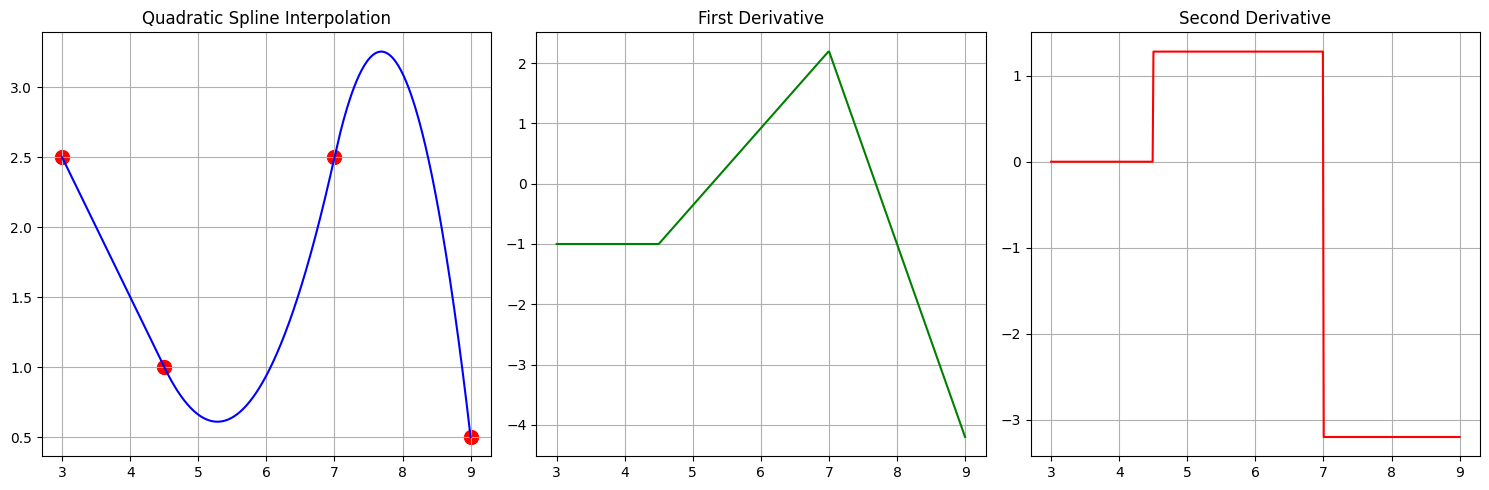


Evaluation at x = 5.0:
  f(5.0) = 0.660000
  f'(5.0) = -0.360000
  f''(5.0) = 1.280000


In [14]:
import numpy as np
import matplotlib.pyplot as plt

def create_quadratic_splines(x_data, y_data):
    """
    Creates quadratic spline interpolation functions for given data points.

    Args:
        x_data: Array of x-coordinates of data points (must be strictly increasing)
        y_data: Array of y-coordinates of data points

    Returns:
        A dictionary containing:
        {
            'spline': Piecewise quadratic function,
            'first_derivative': First derivative function,
            'second_derivative': Second derivative function,
            'coefficients': List of (a, b, c) coefficients for each segment
        }
    """
    # Input validation
    if len(x_data) != len(y_data):
        raise ValueError("x_data and y_data must have the same length")
    if len(x_data) < 2:
        raise ValueError("At least 2 points are needed for interpolation")
    if not np.all(np.diff(x_data) > 0):
        raise ValueError("x_data must be strictly increasing")

    n = len(x_data) - 1  # Number of intervals

    # Initialize matrix and vector for Ax = b
    A = np.zeros((3*n, 3*n))
    b = np.zeros(3*n)

    # 1. Function values at knots (2n conditions)
    row = 0
    for i in range(n):
        # Left side of interval
        A[row, 3*i:3*i+3] = [x_data[i]**2, x_data[i], 1]
        b[row] = y_data[i]
        row += 1

        # Right side of interval
        A[row, 3*i:3*i+3] = [x_data[i+1]**2, x_data[i+1], 1]
        b[row] = y_data[i+1]
        row += 1

    # 2. Derivative continuity (n-1 conditions)
    for i in range(n-1):
        A[row, 3*i:3*i+3] = [2*x_data[i+1], 1, 0]
        A[row, 3*(i+1):3*(i+1)+3] = [-2*x_data[i+1], -1, 0]
        row += 1

    # 3. Set first spline as linear (a1=0) to get unique solution
    A[row, 0] = 1  # a1 = 0
    row += 1

    # Solve the system
    coeffs = np.linalg.solve(A[:row], b[:row])

    # Extract coefficients for each spline
    splines = []
    for i in range(n):
        a, b_coef, c = coeffs[3*i:3*i+3]
        splines.append((a, b_coef, c))

    # Create piecewise functions
    def spline_function(x_eval):
        for i in range(n):
            if x_data[i] <= x_eval <= x_data[i+1]:
                a, b_coef, c = splines[i]
                return a*x_eval**2 + b_coef*x_eval + c
        return np.nan

    def first_derivative(x_eval):
        for i in range(n):
            if x_data[i] <= x_eval <= x_data[i+1]:
                a, b_coef, _ = splines[i]
                return 2*a*x_eval + b_coef
        return np.nan

    def second_derivative(x_eval):
        for i in range(n):
            if x_data[i] <= x_eval <= x_data[i+1]:
                a, _, _ = splines[i]
                return 2*a
        return np.nan

    return {
        'spline': spline_function,
        'first_derivative': first_derivative,
        'second_derivative': second_derivative,
        'coefficients': splines
    }

def plot_spline_results(x_data, y_data, spline_functions):
    """
    Plots the spline interpolation and its derivatives.
    """
    x_fine = np.linspace(x_data[0], x_data[-1], 500)

    # Evaluate functions
    y_fine = np.array([spline_functions['spline'](xi) for xi in x_fine])
    dy_fine = np.array([spline_functions['first_derivative'](xi) for xi in x_fine])
    d2y_fine = np.array([spline_functions['second_derivative'](xi) for xi in x_fine])

    # Plotting
    plt.figure(figsize=(15, 5))

    # Function plot
    plt.subplot(1, 3, 1)
    plt.plot(x_fine, y_fine, 'b-')
    plt.scatter(x_data, y_data, color='red', s=100)
    plt.title('Quadratic Spline Interpolation')
    plt.grid(True)

    # First derivative plot
    plt.subplot(1, 3, 2)
    plt.plot(x_fine, dy_fine, 'g-')
    plt.title('First Derivative')
    plt.grid(True)

    # Second derivative plot
    plt.subplot(1, 3, 3)
    plt.plot(x_fine, d2y_fine, 'r-')
    plt.title('Second Derivative')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Your data
    x_data = np.array([3.0, 4.5, 7.0, 9.0])
    y_data = np.array([2.5, 1.0, 2.5, 0.5])

    # Create splines
    spline_functions = create_quadratic_splines(x_data, y_data)

    # Print coefficients
    print("Spline coefficients:")
    for i, (a, b, c) in enumerate(spline_functions['coefficients']):
        print(f"Segment {i+1} ({x_data[i]} ≤ x ≤ {x_data[i+1]}):")
        print(f"  f(x) = {a:.6f}x² + {b:.6f}x + {c:.6f}")

    # Plot results
    plot_spline_results(x_data, y_data, spline_functions)

    # Evaluate at specific point
    x_eval = 5.0
    print(f"\nEvaluation at x = {x_eval}:")
    print(f"  f({x_eval}) = {spline_functions['spline'](x_eval):.6f}")
    print(f"  f'({x_eval}) = {spline_functions['first_derivative'](x_eval):.6f}")
    print(f"  f''({x_eval}) = {spline_functions['second_derivative'](x_eval):.6f}")

There are two shortcomings that detract from the quadratic fit:
(1) the straight line connecting the first two points and
(2) the spline for the last interval seems to swing too high.

Cubic spline coefficients (a + b(x-x_i) + c(x-x_i)^2 + d(x-x_i)^3):
Segment 1 (3.0 ≤ x < 4.5):
  a = 2.500000, b = -1.419772, c = 0.000000, d = 0.186565
Segment 2 (4.5 ≤ x < 7.0):
  a = 1.000000, b = -0.160456, c = 0.839544, d = -0.214144
Segment 3 (7.0 ≤ x < 9.0):
  a = 2.500000, b = 0.022053, c = -0.766540, d = 0.127757


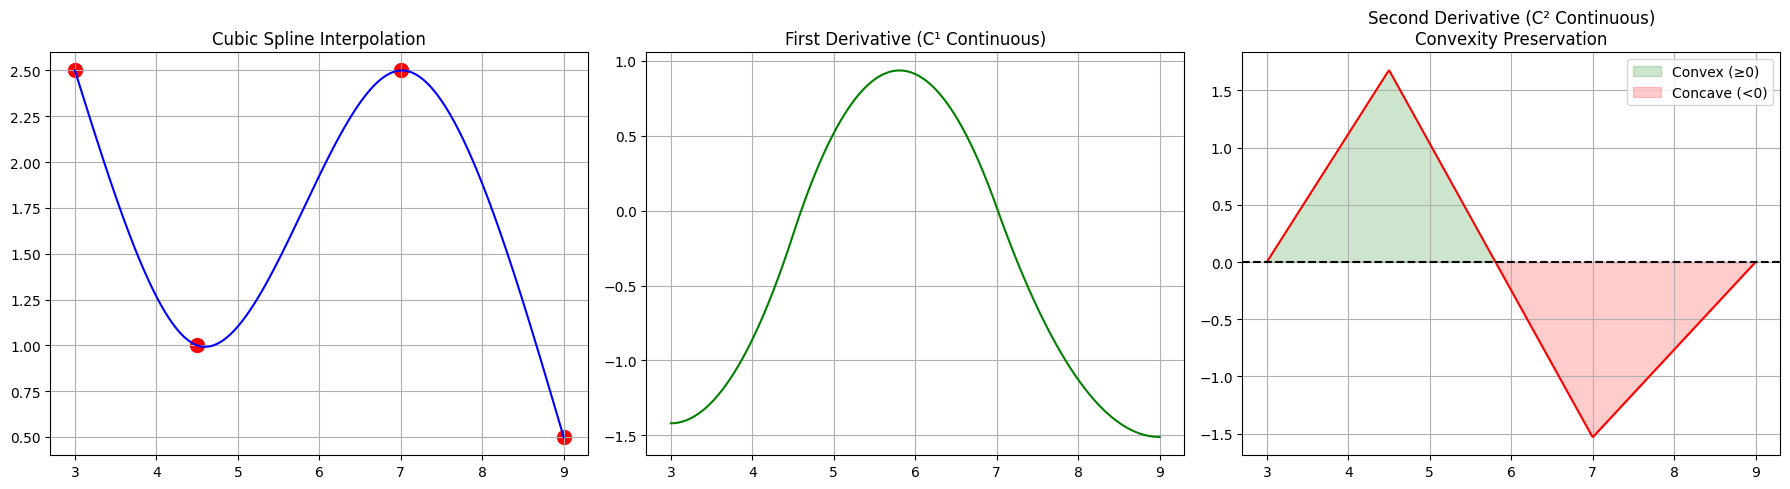


Evaluation at x = 5.0:
  f(5.0) = 1.102890
  f'(5.0) = 0.518479
  f''(5.0) = 1.036654
  Convexity at x=5.0: Convex


In [15]:
import numpy as np
import matplotlib.pyplot as plt

def create_cubic_splines(x_data, y_data):
    """
    Creates cubic spline interpolation functions that preserve convexity.

    Args:
        x_data: Array of strictly increasing x-coordinates
        y_data: Array of corresponding y-coordinates

    Returns:
        Dictionary containing:
        - 'spline': Piecewise cubic function
        - 'first_derivative': First derivative function
        - 'second_derivative': Second derivative function
        - 'coefficients': List of (a, b, c, d) coefficients for each segment
    """
    # Input validation
    if len(x_data) != len(y_data):
        raise ValueError("x_data and y_data must have same length")
    if len(x_data) < 2:
        raise ValueError("At least 2 points required")
    if not np.all(np.diff(x_data) > 0):
        raise ValueError("x_data must be strictly increasing")

    n = len(x_data) - 1  # Number of intervals
    h = np.diff(x_data)   # Interval lengths

    # 1. Set up tridiagonal system for c coefficients
    A = np.zeros((n+1, n+1))
    rhs = np.zeros(n+1)

    # Natural spline conditions (c_0 = c_n = 0)
    A[0, 0] = 1
    A[n, n] = 1

    # Fill inner equations (continuity of second derivatives)
    for i in range(1, n):
        A[i, i-1] = h[i-1]
        A[i, i] = 2*(h[i-1] + h[i])
        A[i, i+1] = h[i]
        rhs[i] = 3*((y_data[i+1] - y_data[i])/h[i] - (y_data[i] - y_data[i-1])/h[i-1])

    # 2. Solve for c coefficients
    c = np.linalg.solve(A, rhs)

    # 3. Compute other coefficients
    a = y_data[:-1]
    d = np.zeros(n)
    b = np.zeros(n)

    for i in range(n):
        d[i] = (c[i+1] - c[i])/(3*h[i])
        b[i] = (y_data[i+1] - y_data[i])/h[i] - h[i]*(2*c[i] + c[i+1])/3

    coefficients = list(zip(a, b, c[:-1], d))

    # Create piecewise functions
    def spline_function(x_eval):
        for i in range(n):
            if x_data[i] <= x_eval <= x_data[i+1]:
                dx = x_eval - x_data[i]
                a_i, b_i, c_i, d_i = coefficients[i]
                return a_i + b_i*dx + c_i*dx**2 + d_i*dx**3
        return np.nan

    def first_derivative(x_eval):
        for i in range(n):
            if x_data[i] <= x_eval <= x_data[i+1]:
                dx = x_eval - x_data[i]
                _, b_i, c_i, d_i = coefficients[i]
                return b_i + 2*c_i*dx + 3*d_i*dx**2
        return np.nan

    def second_derivative(x_eval):
        for i in range(n):
            if x_data[i] <= x_eval <= x_data[i+1]:
                dx = x_eval - x_data[i]
                _, _, c_i, d_i = coefficients[i]
                return 2*c_i + 6*d_i*dx
        return np.nan

    return {
        'spline': spline_function,
        'first_derivative': first_derivative,
        'second_derivative': second_derivative,
        'coefficients': coefficients
    }

def plot_cubic_spline_results(x_data, y_data, spline_functions):
    """Visualizes spline and derivatives with convexity highlighting."""
    x_fine = np.linspace(x_data[0], x_data[-1], 500)

    # Evaluate functions
    y_fine = np.array([spline_functions['spline'](xi) for xi in x_fine])
    dy_fine = np.array([spline_functions['first_derivative'](xi) for xi in x_fine])
    d2y_fine = np.array([spline_functions['second_derivative'](xi) for xi in x_fine])

    # Create plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Spline plot
    ax1.plot(x_fine, y_fine, 'b-')
    ax1.scatter(x_data, y_data, color='red', s=100)
    ax1.set_title('Cubic Spline Interpolation')
    ax1.grid(True)

    # First derivative plot
    ax2.plot(x_fine, dy_fine, 'g-')
    ax2.set_title('First Derivative (C¹ Continuous)')
    ax2.grid(True)

    # Second derivative plot with convexity highlighting
    ax3.plot(x_fine, d2y_fine, 'r-')

    # Highlight convexity regions
    convex_mask = d2y_fine >= 0
    concave_mask = d2y_fine < 0
    ax3.fill_between(x_fine, d2y_fine, where=convex_mask, color='green', alpha=0.2, label='Convex (≥0)')
    ax3.fill_between(x_fine, d2y_fine, where=concave_mask, color='red', alpha=0.2, label='Concave (<0)')

    ax3.axhline(0, color='black', linestyle='--')
    ax3.set_title('Second Derivative (C² Continuous)\nConvexity Preservation')
    ax3.grid(True)
    ax3.legend()

    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Example data (from your image)
    x_data = np.array([3.0, 4.5, 7.0, 9.0])
    y_data = np.array([2.5, 1.0, 2.5, 0.5])

    # Create splines
    spline_functions = create_cubic_splines(x_data, y_data)

    # Print coefficients
    print("Cubic spline coefficients (a + b(x-x_i) + c(x-x_i)^2 + d(x-x_i)^3):")
    for i, (a, b, c, d) in enumerate(spline_functions['coefficients']):
        print(f"Segment {i+1} ({x_data[i]} ≤ x < {x_data[i+1]}):")
        print(f"  a = {a:.6f}, b = {b:.6f}, c = {c:.6f}, d = {d:.6f}")

    # Plot results
    plot_cubic_spline_results(x_data, y_data, spline_functions)

    # Evaluate at specific point (x=5 from your example)
    x_eval = 5.0
    print(f"\nEvaluation at x = {x_eval}:")
    print(f"  f({x_eval}) = {spline_functions['spline'](x_eval):.6f}")
    print(f"  f'({x_eval}) = {spline_functions['first_derivative'](x_eval):.6f}")
    print(f"  f''({x_eval}) = {spline_functions['second_derivative'](x_eval):.6f}")
    print(f"  Convexity at x={x_eval}: {'Convex' if spline_functions['second_derivative'](x_eval) >= 0 else 'Concave'}")

so cubic one is best but lets compare between it and the quadratic one.also why is this better than higher order polynomial interpolation

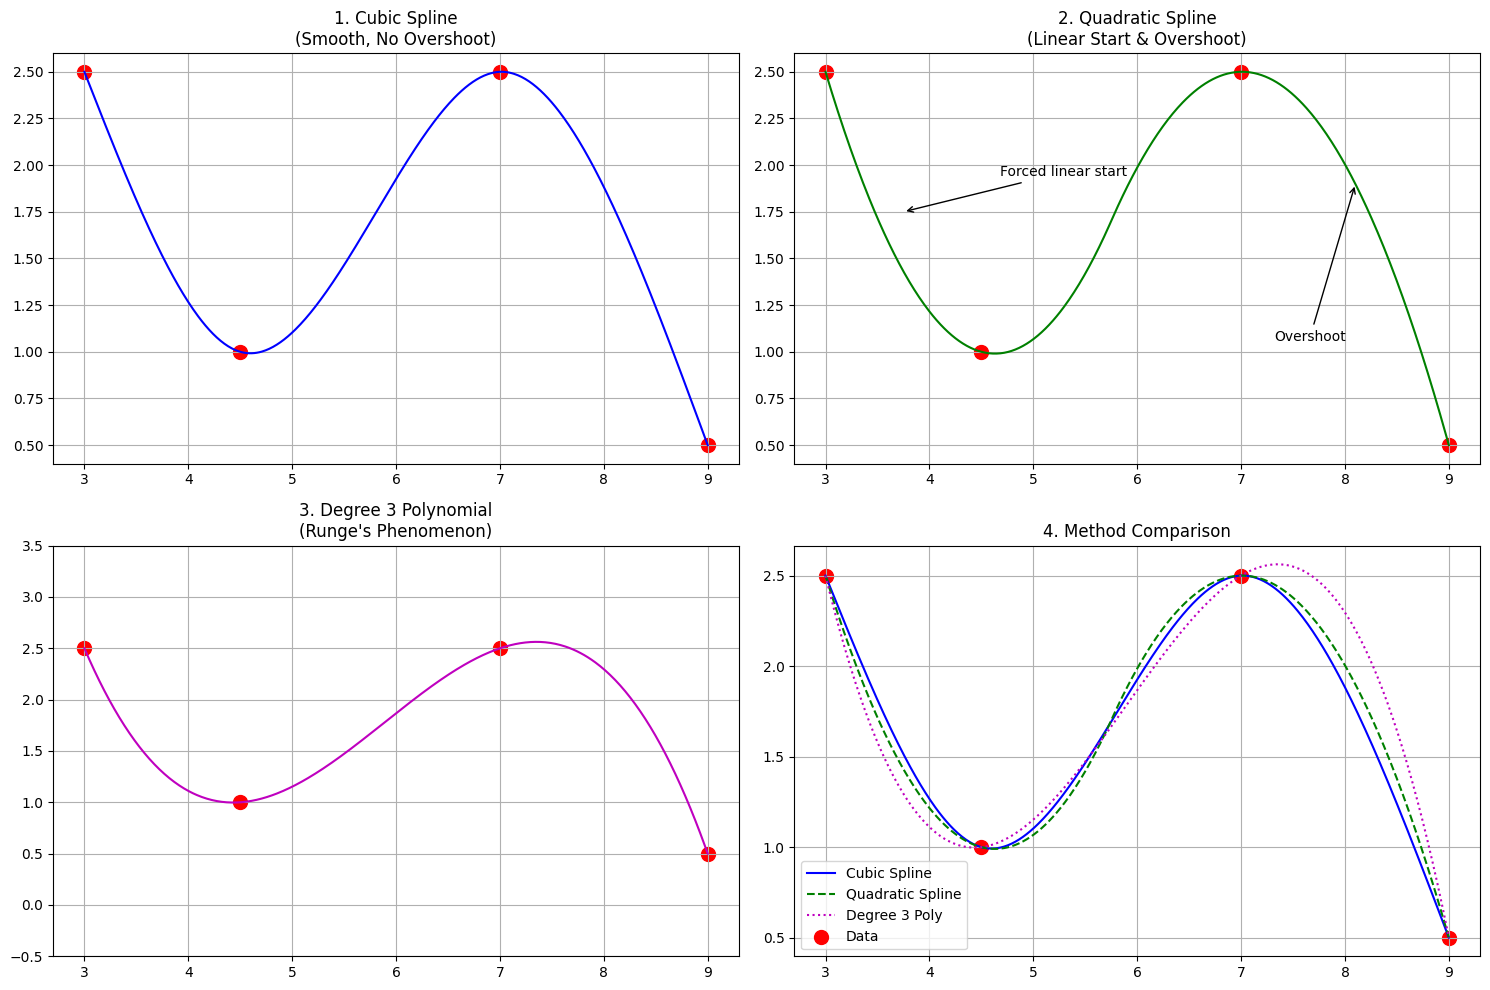


Method Comparison at x = 5.875
Cubic spline: 1.8099
Quadratic spline: 1.8516
Polynomial: 1.7663


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, InterpolatedUnivariateSpline
from numpy.polynomial.polynomial import Polynomial

def compare_interpolation_methods(x_data, y_data):
    """
    Compare cubic splines vs quadratic splines vs high-order polynomials
    using SciPy's optimized implementations.
    """
    # Generate fine grid for plotting
    x_fine = np.linspace(min(x_data), max(x_data), 500)

    # Create figure
    plt.figure(figsize=(15, 10))

    # 1. Cubic Spline (C^2 continuous)
    plt.subplot(2, 2, 1)
    cs = CubicSpline(x_data, y_data, bc_type='natural')
    plt.plot(x_fine, cs(x_fine), 'b-', label='Cubic Spline')
    plt.scatter(x_data, y_data, color='red', s=100)
    plt.title('1. Cubic Spline\n(Smooth, No Overshoot)')
    plt.grid(True)

    # 2. Quadratic Spline (C^1 continuous)
    plt.subplot(2, 2, 2)
    qs = InterpolatedUnivariateSpline(x_data, y_data, k=2)  # k=2 for quadratic
    plt.plot(x_fine, qs(x_fine), 'g-', label='Quadratic Spline')
    plt.scatter(x_data, y_data, color='red', s=100)

    # Highlight quadratic spline issues
    plt.annotate('Forced linear start', xy=(np.mean(x_data[:2]), np.mean(y_data[:2])),
                 xytext=(0.3, 0.7), textcoords='axes fraction',
                 arrowprops=dict(arrowstyle="->"))
    plt.annotate('Overshoot', xy=(x_data[-1]*0.9, qs(x_data[-1]*0.9)),
                 xytext=(0.7, 0.3), textcoords='axes fraction',
                 arrowprops=dict(arrowstyle="->"))
    plt.title('2. Quadratic Spline\n(Linear Start & Overshoot)')
    plt.grid(True)

    # 3. High-order Polynomial (Problematic)
    plt.subplot(2, 2, 3)
    poly_coeffs = np.polyfit(x_data, y_data, deg=len(x_data)-1)
    poly = np.poly1d(poly_coeffs)
    plt.plot(x_fine, poly(x_fine), 'm-', label=f'Degree {len(x_data)-1} Poly')
    plt.scatter(x_data, y_data, color='red', s=100)

    # Adjust y-limits to show oscillations
    y_pad = 0.5 * (max(y_data) - min(y_data))
    plt.ylim(min(y_data)-y_pad, max(y_data)+y_pad)
    plt.title(f'3. Degree {len(x_data)-1} Polynomial\n(Runge\'s Phenomenon)')
    plt.grid(True)

    # 4. All Methods Comparison
    plt.subplot(2, 2, 4)
    plt.plot(x_fine, cs(x_fine), 'b-', label='Cubic Spline')
    plt.plot(x_fine, qs(x_fine), 'g--', label='Quadratic Spline')
    plt.plot(x_fine, poly(x_fine), 'm:', label=f'Degree {len(x_data)-1} Poly')
    plt.scatter(x_data, y_data, color='red', s=100, label='Data')
    plt.title('4. Method Comparison')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Quantitative comparison
    x_test = np.mean(x_data)
    print("\nMethod Comparison at x =", x_test)
    print(f"Cubic spline: {cs(x_test):.4f}")
    print(f"Quadratic spline: {qs(x_test):.4f}")
    print(f"Polynomial: {poly(x_test):.4f}")

# Example usage with your data
x_data = np.array([3.0, 4.5, 7.0, 9.0])
y_data = np.array([2.5, 1.0, 2.5, 0.5])
compare_interpolation_methods(x_data, y_data)

Multidimensional Interpolation
The interpolation methods for 1D problems can be extended to
multidimensional interpolation. The simplest case of 2D
interpolation in Cartesian coordinates is denoted by Bilinear
Interpolation.

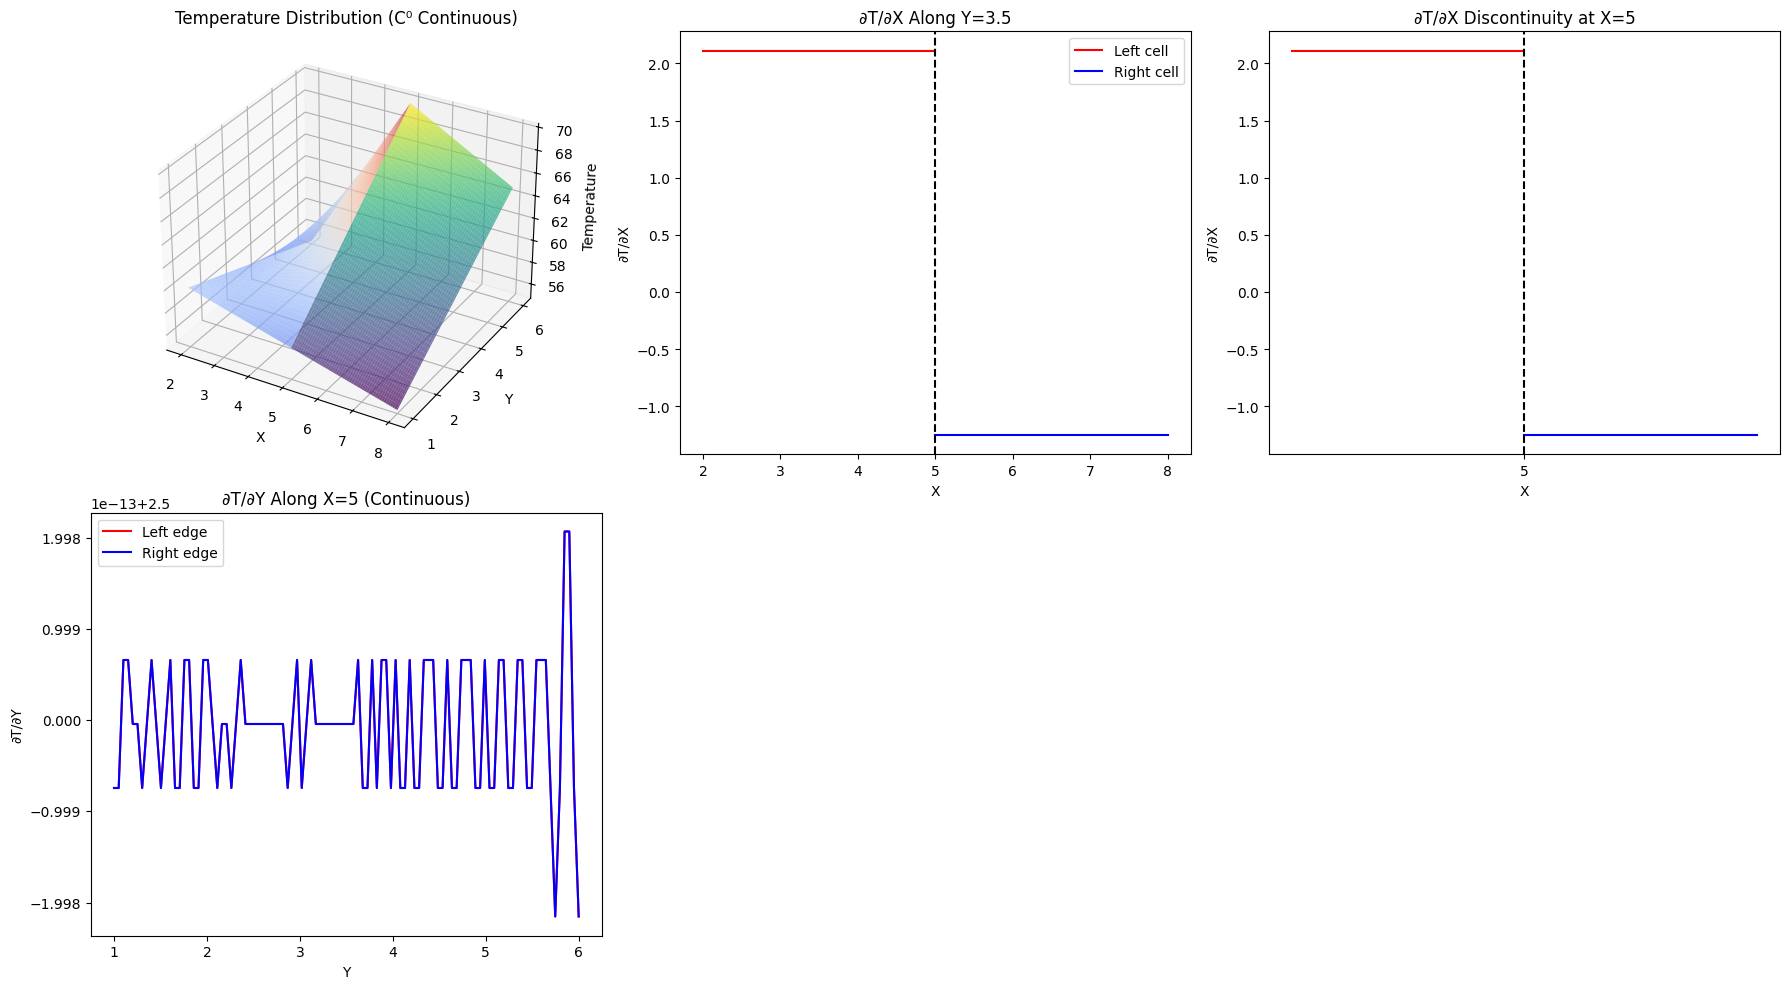


Temperature Derivative Discontinuity Demonstration:
Left cell ∂T/∂X at X=5: 2.1128
Right cell ∂T/∂X at X=5: -1.2542
Discontinuity Magnitude: 3.3670


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def bilinear_interpolation(x, y, points):
    """Perform bilinear interpolation within a cell defined by 4 corner points"""
    # Extract points explicitly by position
    try:
        q11 = points[(2, 1)]
        q21 = points[(5, 1)]
        q12 = points[(2, 6)]
        q22 = points[(5, 6)]
        x1, x2 = 2, 5
        y1, y2 = 1, 6
    except KeyError:
        try:
            q11 = points[(5, 1)]
            q21 = points[(8, 1)]
            q12 = points[(5, 6)]
            q22 = points[(8, 6)]
            x1, x2 = 5, 8
            y1, y2 = 1, 6
        except KeyError:
            return np.nan

    # Boundary check
    if x < x1 or x > x2 or y < y1 or y > y2:
        return np.nan

    # Compute interpolation weights
    wx = (x - x1) / (x2 - x1)
    wy = (y - y1) / (y2 - y1)

    # Bilinear interpolation
    return (1 - wx) * (1 - wy) * q11 + wx * (1 - wy) * q21 + (1 - wx) * wy * q12 + wx * wy * q22


def plot_temperature_cells():
    """Visualize two adjacent temperature cells showing C⁰ continuity and C¹ discontinuity"""
    plt.close('all')

    # Define temperature at corners
    left_cell = {
        (2, 1): 60,
        (5, 1): 57.5,
        (2, 6): 55,
        (5, 6): 70
    }

    right_cell = {
        (5, 1): 57.5,
        (8, 1): 55,
        (5, 6): 70,
        (8, 6): 65
    }

    # Grid resolution
    res = 100
    x_left = np.linspace(2, 5, res)
    x_right = np.linspace(5, 8, res)
    y = np.linspace(1, 6, res)

    X_left, Y_left = np.meshgrid(x_left, y)
    X_right, Y_right = np.meshgrid(x_right, y)

    Z_left = np.array([[bilinear_interpolation(x, y_, left_cell) for x in x_left] for y_ in y])
    Z_right = np.array([[bilinear_interpolation(x, y_, right_cell) for x in x_right] for y_ in y])

    dx = x_left[1] - x_left[0]
    dy = y[1] - y[0]

    dZ_left_dx = np.gradient(Z_left, dx, axis=1)
    dZ_right_dx = np.gradient(Z_right, dx, axis=1)
    dZ_left_dy = np.gradient(Z_left, dy, axis=0)
    dZ_right_dy = np.gradient(Z_right, dy, axis=0)

    fig = plt.figure(figsize=(18, 10))

    # Surface plot
    ax1 = fig.add_subplot(231, projection='3d')
    ax1.plot_surface(X_left, Y_left, Z_left, cmap='coolwarm', alpha=0.7)
    ax1.plot_surface(X_right, Y_right, Z_right, cmap='viridis', alpha=0.7)
    ax1.set_title('Temperature Distribution (C⁰ Continuous)')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Temperature')

    # Derivatives along Y=3.5
    mid_y = res // 2
    ax2 = fig.add_subplot(232)
    ax2.plot(x_left, dZ_left_dx[mid_y, :], 'r-', label='Left cell')
    ax2.plot(x_right, dZ_right_dx[mid_y, :], 'b-', label='Right cell')
    ax2.axvline(x=5, color='k', linestyle='--')
    ax2.set_title('∂T/∂X Along Y=3.5')
    ax2.set_xlabel('X')
    ax2.set_ylabel('∂T/∂X')
    ax2.legend()

    # Highlight discontinuity
    ax3 = fig.add_subplot(233)
    ax3.plot(x_left[-10:], dZ_left_dx[mid_y, -10:], 'r-')
    ax3.plot(x_right[:10], dZ_right_dx[mid_y, :10], 'b-')
    ax3.axvline(x=5, color='k', linestyle='--')
    ax3.set_title('∂T/∂X Discontinuity at X=5')
    ax3.set_xlabel('X')
    ax3.set_ylabel('∂T/∂X')
    ax3.set_xticks([5])

    # Y-derivative continuity
    ax4 = fig.add_subplot(234)
    ax4.plot(y, dZ_left_dy[:, -1], 'r-', label='Left edge')
    ax4.plot(y, dZ_right_dy[:, 0], 'b-', label='Right edge')
    ax4.set_title('∂T/∂Y Along X=5 (Continuous)')
    ax4.set_xlabel('Y')
    ax4.set_ylabel('∂T/∂Y')
    ax4.legend()



    plt.tight_layout()
    plt.show()

    print("\nTemperature Derivative Discontinuity Demonstration:")
    print(f"Left cell ∂T/∂X at X=5: {dZ_left_dx[mid_y, -1]:.4f}")
    print(f"Right cell ∂T/∂X at X=5: {dZ_right_dx[mid_y, 0]:.4f}")
    print(f"Discontinuity Magnitude: {abs(dZ_right_dx[mid_y, 0] - dZ_left_dx[mid_y, -1]):.4f}")

# Run
plot_temperature_cells()


let us

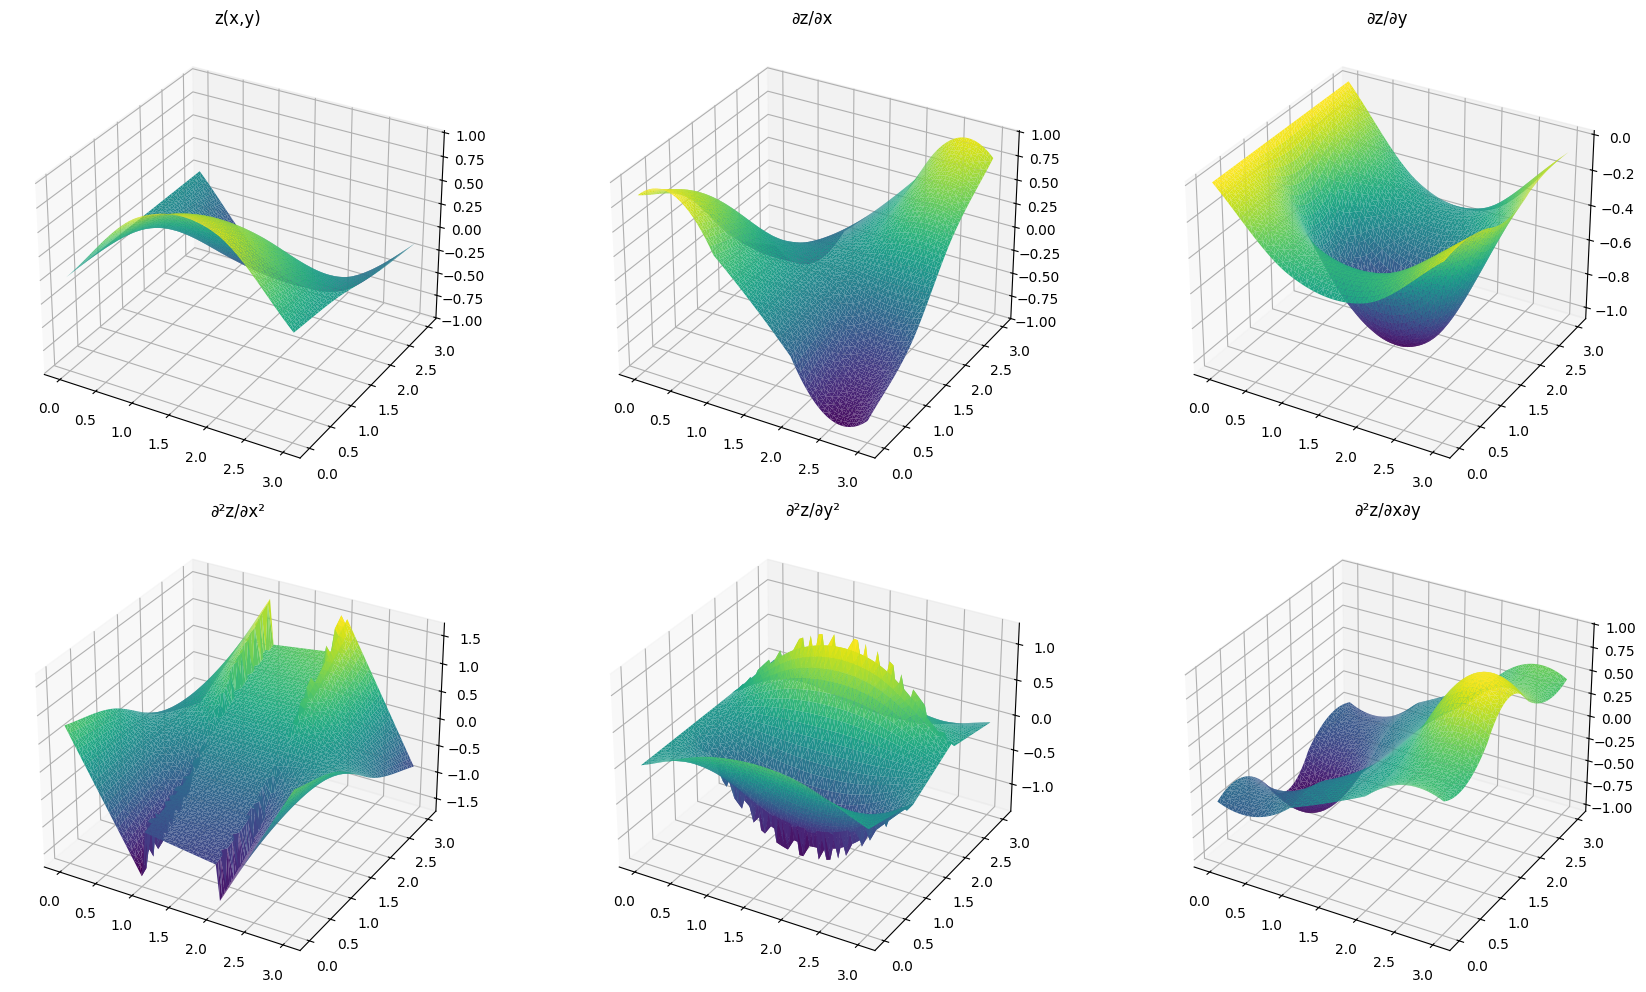

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to generate bicubic interpolation coefficients for a single cell
def compute_bicubic_coeffs(f, fx, fy, fxy):
    """
    f, fx, fy, fxy are all 2x2 arrays for the four corners of a grid cell.
    """
    M = np.array([
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [-3, 3, -2, -1],
        [2, -2, 1, 1]
    ])

    G = np.array([
        [f[0, 0], f[0, 1], fy[0, 0], fy[0, 1]],
        [f[1, 0], f[1, 1], fy[1, 0], fy[1, 1]],
        [fx[0, 0], fx[0, 1], fxy[0, 0], fxy[0, 1]],
        [fx[1, 0], fx[1, 1], fxy[1, 0], fxy[1, 1]]
    ])

    return M @ G @ M.T

# Evaluate the bicubic patch and derivatives
def eval_patch(coeffs, u, v):
    U = np.array([1, u, u**2, u**3])
    dU = np.array([0, 1, 2*u, 3*u**2])
    d2U = np.array([0, 0, 2, 6*u])

    V = np.array([1, v, v**2, v**3])
    dV = np.array([0, 1, 2*v, 3*v**2])
    d2V = np.array([0, 0, 2, 6*v])

    z = U @ coeffs @ V
    dzdx = dU @ coeffs @ V
    dzdy = U @ coeffs @ dV
    d2zdx2 = d2U @ coeffs @ V
    d2zdy2 = U @ coeffs @ d2V
    d2zdxdy = dU @ coeffs @ dV

    return z, dzdx, dzdy, d2zdx2, d2zdy2, d2zdxdy

# Main interpolation function
def bicubic_interpolate_grid(x, y, z, resolution=20):
    nx, ny = len(x), len(y)
    X = []
    Y = []
    Z = []
    dZdx = []
    dZdy = []
    d2Zdx2 = []
    d2Zdy2 = []
    d2Zdxdy = []

    # Estimate derivatives using central differences
    fx = np.gradient(z, x, axis=0)
    fy = np.gradient(z, y, axis=1)
    fxy = np.gradient(fx, y, axis=1)

    for i in range(nx - 1):
        for j in range(ny - 1):
            f = z[i:i+2, j:j+2]
            dfx = fx[i:i+2, j:j+2]
            dfy = fy[i:i+2, j:j+2]
            dfxy = fxy[i:i+2, j:j+2]
            coeffs = compute_bicubic_coeffs(f, dfx, dfy, dfxy)

            u_vals = np.linspace(0, 1, resolution)
            v_vals = np.linspace(0, 1, resolution)
            for u in u_vals:
                for v in v_vals:
                    _z, _dx, _dy, _dxx, _dyy, _dxy = eval_patch(coeffs, u, v)

                    x_pos = x[i] + u * (x[i+1] - x[i])
                    y_pos = y[j] + v * (y[j+1] - y[j])

                    X.append(x_pos)
                    Y.append(y_pos)
                    Z.append(_z)
                    dZdx.append(_dx)
                    dZdy.append(_dy)
                    d2Zdx2.append(_dxx)
                    d2Zdy2.append(_dyy)
                    d2Zdxdy.append(_dxy)

    return np.array(X), np.array(Y), np.array(Z), np.array(dZdx), np.array(dZdy), np.array(d2Zdx2), np.array(d2Zdy2), np.array(d2Zdxdy)

# Plotting function
def plot_surfaces(X, Y, surfaces, titles):
    fig = plt.figure(figsize=(18, 10))
    for i, (Z, title) in enumerate(zip(surfaces, titles)):
        ax = fig.add_subplot(2, 3, i+1, projection='3d')
        ax.plot_trisurf(X, Y, Z, cmap='viridis', linewidth=0.1)
        ax.set_title(title)
    plt.tight_layout()
    plt.show()

# Sample input grid and test
x = np.linspace(0, 3, 4)
y = np.linspace(0, 3, 4)
Xg, Yg = np.meshgrid(x, y, indexing='ij')
Zg = np.sin(Xg) * np.cos(Yg)

# Run interpolation
X, Y, Z, dZdx, dZdy, d2Zdx2, d2Zdy2, d2Zdxdy = bicubic_interpolate_grid(x, y, Zg)

# Plot results
plot_surfaces(X, Y, [Z, dZdx, dZdy, d2Zdx2, d2Zdy2, d2Zdxdy],
              ["z(x,y)", "∂z/∂x", "∂z/∂y", "∂²z/∂x²", "∂²z/∂y²", "∂²z/∂x∂y"])

